In [6]:
!unzip test/test.zip
!unzip train/train.zip

Archive:  test/test.zip
replace test/21765.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train/train.zip
replace train/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, activations
%matplotlib inline

In [0]:
img = cv2.imread('train/00000.jpg')

(128, 128, 3)


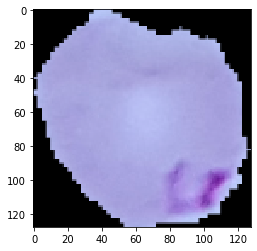

In [9]:
plt.imshow(img)
print(img.shape)

In [0]:
def load_images_from_folder(folder):
  images = []
  file_paths = []
  for imgname in os.listdir(folder):
    if imgname=='.ipynb_checkpoints':
      continue
    file_paths.append(os.path.join(folder,imgname))
  file_paths = sorted(file_paths)
  for file_path in file_paths:
    img = cv2.imread(os.path.join(file_path))
    if img is not None:
      images.append(img)
  return images, file_paths

In [0]:
X_train, file_paths = load_images_from_folder("train")
X_test, _ = load_images_from_folder("test")
y_train_df = pd.read_csv("train_labels.csv")

In [13]:
y_train_df.head()

,filename,infected
0,00000.jpg,1
1,00001.jpg,1
2,00002.jpg,1
3,00003.jpg,0
4,00004.jpg,0


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = y_train_df['infected'].values

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(21765, 128, 128, 3)
(5793, 128, 128, 3)
(21765,)


In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Build model

In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [17]:
num_epochs = [15,17,19,21,23]
y_preds = []
ensemble_dict = {}

for num_epoch in num_epochs:
    densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(128,128,3),
)
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history_model1 = model.fit(X_train,
                           y_train,
                           batch_size=64,
                           epochs=num_epoch,
                           verbose=1,
                           validation_split=0.05,
                          )
    y_preds.append(model.predict(X_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20676 samples, validate on 1089 samples
Epoch 1/15
20676/20676 [==============================] - 78s 4ms/sample - loss: 0.2288 - acc: 0.9130 - val_loss: 1.7492 - val_acc: 0.6318
Epoch 2/15
20676/20676 [==============================] - 56s 3ms/sample - loss: 0.1346 - acc: 0.9557 - val_loss: 0.1487 - val_acc: 0.9660
Epoch 3/15
20676/20676 [==============================] - 56s 3ms/sample - loss: 0.1277 - acc: 0.9577 - val_loss: 0.1586 - val_acc: 0.9486
Epoch 4/15
20676/20676 [==============================] - 56s 3ms/sample - loss: 0.1224 - acc: 0.9580 - val_loss: 0.4164 - val_acc: 0.8962
Epoch 5/15
20676/20676 [==============================] - 56s 3ms/sample - loss: 0.1331 - acc: 0.9542 - val_loss: 0.1107 - val_acc: 0.9669
Epoch 6/15
20676/20676 [==============================] - 56s 3ms/sample - loss: 

In [18]:
preds = np.array(y_preds)
preds = preds.reshape((5,-1)).T
preds.shape

(5793, 5)

In [25]:
y_test_pred_proba_df = pd.DataFrame(preds, columns=[str(num_epoch)+"_epochs_pred" for num_epoch in num_epochs])
y_test_pred_proba_df.to_csv("y_test_pred_proba", index=False)
y_test_pred_proba_df.head()

,15_epochs_pred,17_epochs_pred,19_epochs_pred,21_epochs_pred,23_epochs_pred
0,0.120005,0.024495,0.210512,0.378962,0.126046
1,0.988582,0.998775,0.999992,0.990500,0.999962
2,0.069110,0.046302,0.032135,0.426586,0.001585
3,0.000220,0.000298,0.009357,0.003934,0.002482
4,0.000094,0.000044,0.000297,0.000924,0.000746


# Averaging ensemble

In [28]:
y_test_pred_proba_df['average'] = y_test_pred_proba_df.mean(axis=1)
y_test_pred_proba_df.head()

,15_epochs_pred,17_epochs_pred,19_epochs_pred,21_epochs_pred,23_epochs_pred,average
0,0.120005,0.024495,0.210512,0.378962,0.126046,0.172004
1,0.988582,0.998775,0.999992,0.990500,0.999962,0.995562
2,0.069110,0.046302,0.032135,0.426586,0.001585,0.115143
3,0.000220,0.000298,0.009357,0.003934,0.002482,0.003258
4,0.000094,0.000044,0.000297,0.000924,0.000746,0.000421


# Get submission

In [0]:
filenames = []
for filename in os.listdir("test"):
    if filename != 'test.zip':
      filenames.append(filename)

In [0]:
y_test_pred_proba_df['filename'] = sorted(filenames)